# Notebook for ZFOURGE CDFS Luminosity (Magnitude) Functions

### Import and setup

In [52]:
# Required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM 

# Load Data
data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')

# Filter Data
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299
df = df[df['FKs'] > 0] # 12,676

# Constants
mag_lim = 25.9 # apparent magnitude limit (same as AB magnitude limit)
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin
lum_bin_edges = np.arange(-30, -12, 0.25) # luminosity bin edges
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # Cosmology

### Calculate Absolute Magnitude

In [53]:
# Data
z = df['zpk'] # redshift
mag_app = df['FKs'] # apparent Ks magnitude
# AB magnitude
mag_ab = 25 - 2.5*np.log10(mag_app) # apparent magnitude -> AB magnitude

# Absolute Magnitude from luminosity distance
dists = cosmo.luminosity_distance(z) * 10 ** 6 # Mpc -> pc
Mag_abs_ld = mag_ab - 5 * np.log10(dists / 10) # AB magnitude -> absolute magnitude

# Mask AB magnitude (same limit)
mask = (mag_ab <= mag_lim)

# Mask data
z = z[mask]
Mag_abs_ld = Mag_abs_ld[mask]

### Maximum Observable Volume

calculated for each galaxy

In [54]:
all_data = []
for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    
    Mag_abs_bin = Mag_abs_ld[mask]
    
    # Calculate the minimum and maximum distance of the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = 10 * 10 ** ((mag_lim - Mag_abs_bin) / 5) # pc
    dmaxs /= 10 ** 6 # pc -> Mpc
    
    # Distances must be greater than the minimum distance
    d_mask = dmaxs >= dmin
    
    # Apply masks
    dmaxs = dmaxs[d_mask]
    mag = Mag_abs_bin[d_mask]
        
    # If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([vol, mag])

### Magnitude Counts

With luminosity and number count completeness limits

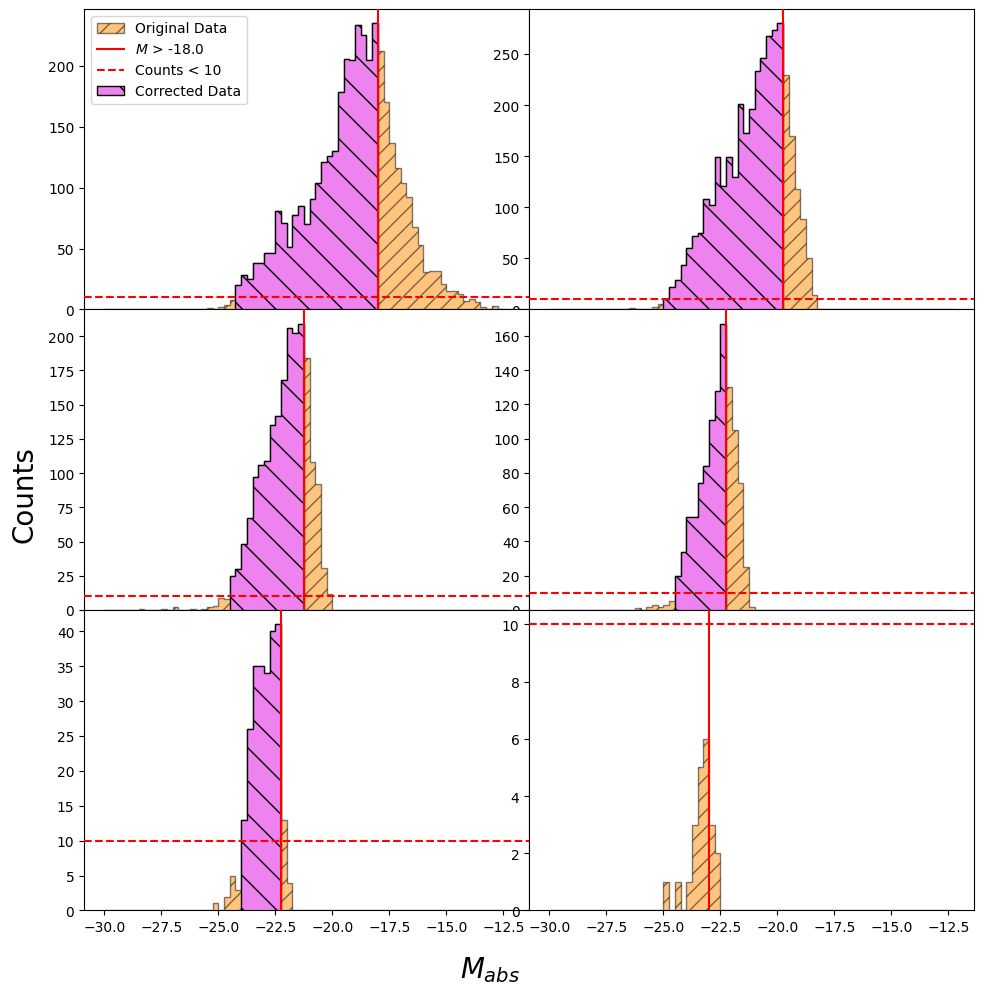

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True)
bin_edges = []
for i, ((z_start, z_end), (vol, mag), ax) in enumerate(zip(redshift_bins, all_data, axes.flatten())):
    
    # Bin the original data
    c, b, _ = ax.hist(Mag_abs_ld[(z >= z_start) & (z < z_end)], bins=lum_bin_edges, histtype='step', label='Original Data', facecolor='darkorange', edgecolor='black', hatch='//', fill=True, alpha=0.5)
    
    # Luminsity completeness limit
    l_lim = np.where(c == np.max(c))[0][0]+1 # peak
    ax.axvline(b[l_lim], color='red', linestyle='-', label=rf'$M$ > {np.round(b[l_lim],2)}', zorder=10)
    mask_l = b[:-1] <= b[:-1][l_lim]
    
    # Minimum  limit
    mask_c = c >= min_count
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}', zorder=10)
       
    try:
        c, b, _ = ax.hist(mag[mag <= b[l_lim]], bins=b[:-1][mask_l & mask_c], histtype='step', label='Corrected Data', facecolor='violet', edgecolor='black', hatch='\\', fill=True)
    except ValueError:
        b = []
    
    if i == 0:
        ax.legend(loc='upper left')
    bin_edges.append(b)

fig.supylabel('Counts', fontsize=20)
fig.supxlabel('$M_{abs}$', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
# plt.savefig('Magnitude Counts', dpi=300)
plt.show()

### Vmax calculation

In [56]:
lum_centers, phi, phi_e = [], [], []

# Volume and magnitude are already binned by redshift
for (vol, mag), bin, in zip(all_data, bin_edges):
    if len(bin) < 2:
        continue
    
    delta_log_l = np.diff(bin)[0]
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (mag >= lum_start) & (mag < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

### Fit Schechter Function

C:\Users\danie\AppData\Local\Temp\ipykernel_15400\2257090005.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))


0 <= z < 1 Function fit:
M_star = -2.44e+01
phi_star = 1.09e-03
alpha = 1.34e+00


1 <= z < 2 Function fit:
M_star = -2.43e+01
phi_star = 1.08e-03
alpha = 1.27e+00


2 <= z < 3 Function fit:
M_star = -2.37e+01
phi_star = 1.56e-03
alpha = 1.18e+00


3 <= z < 4 Function fit:
M_star = -2.52e+01
phi_star = 2.19e-04
alpha = 1.79e+00


4 <= z < 5 Function fit:
M_star = -2.28e+01
phi_star = 1.16e-03
alpha = 2.00e-01




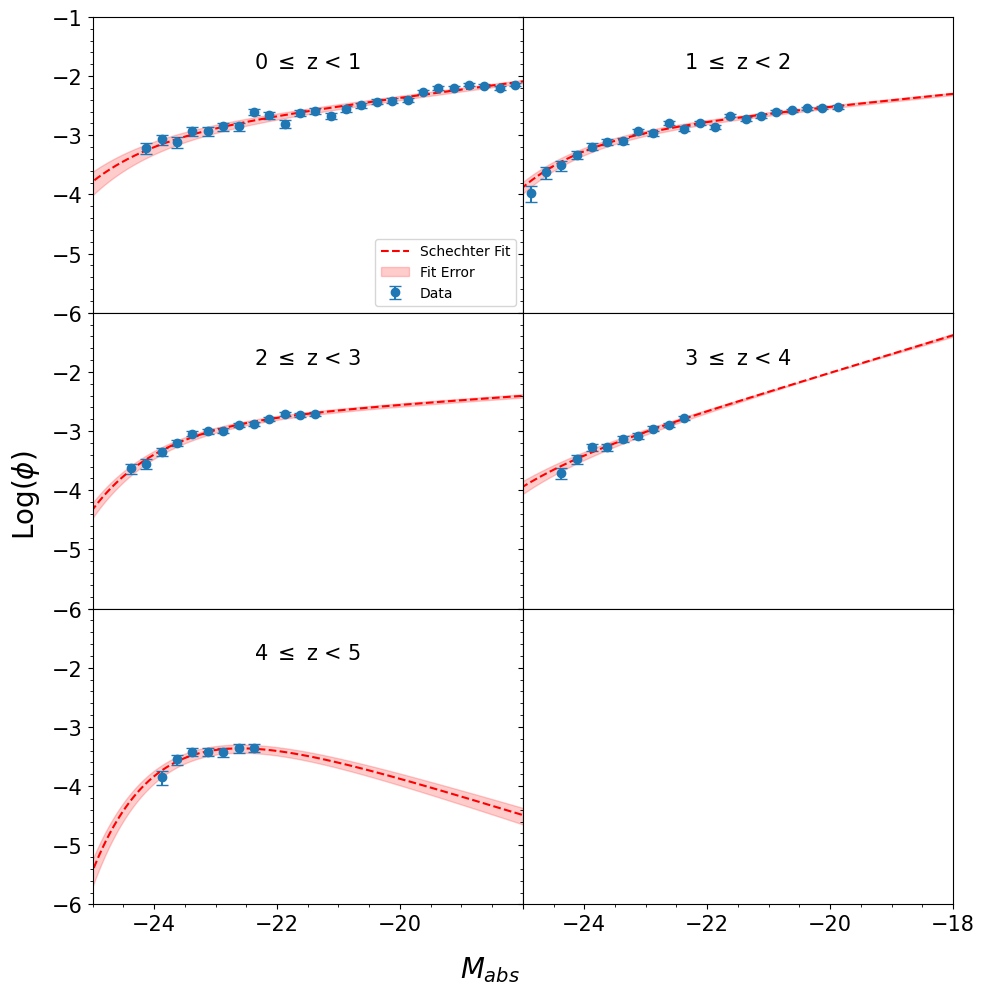

In [57]:
def schechter_magnitude(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
for i, ((z_start, z_end), lum, p, e, ax) in enumerate(zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten())):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0=[lum[0], 0.001, -0.9]
    try:
        params, covars = curve_fit(schechter_magnitude, lum, p, p0=p0, maxfev=10000)
        p_up, _ = curve_fit(schechter_magnitude, lum, p+e, p0=p0, maxfev=10000)
        p_down, _ = curve_fit(schechter_magnitude, lum, p-e, p0=p0, maxfev=10000)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    long_lum = np.linspace(-26, -17, 1000)
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, fmt='o', capsize=4, label='Data')
    ax.plot(long_lum, np.log10(schechter_magnitude(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(long_lum, 
        np.log10(schechter_magnitude(long_lum, *p_down)),
        np.log10(schechter_magnitude(long_lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}', y=0.8, fontsize=15)
    ax.set_xlim(-25, -18)
    ax.set_ylim(-6, -1)
    if i == 0:
        ax.legend(loc='lower right')
    ax.tick_params(axis='both', labelsize=15)
    ax.minorticks_on()
        
axes.flatten()[2].yaxis.get_major_ticks()[-1].label1.set_visible(False)
axes.flatten()[4].yaxis.get_major_ticks()[-1].label1.set_visible(False)

axes.flatten()[4].xaxis.get_major_ticks()[-1].label1.set_visible(False)
axes.flatten()[5].tick_params(axis='both', labelsize=15)

fig.supxlabel('$M_{abs}$', fontsize=20)
fig.supylabel('Log($\phi$)', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
# plt.savefig('Magnitude Function', dpi=300)
plt.show()